# 2019320016 차주한

### Preprocess data using leammatizer

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    # text = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hanchaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load dataset and split into train & validation

In [2]:
import torch
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset

mail_field = data.Field(sequential=True, use_vocab=True, tokenize=str.split, lower=True, batch_first=True, fix_length=500)
label_field = data.Field(sequential=False, use_vocab=False, batch_first=False, is_target=True)
id_field = data.Field(sequential=False, use_vocab=False, batch_first=False, is_target=True)

loaded_data = TabularDataset(path="./data/train.csv",
                                 format="csv",
                                 fields=[("id" , id_field), ("label", label_field), ("mail", mail_field)],
                                 skip_header=True)

train_data, val_data = loaded_data.split(split_ratio=0.7, stratified=True, strata_field="label")

print("train data: ", len(train_data))
print(train_data.fields)
print("validation data: ", len(val_data))
print(val_data.fields)

train data:  2534
{'id': <torchtext.legacy.data.field.Field object at 0x0000019A146B2B50>, 'label': <torchtext.legacy.data.field.Field object at 0x0000019A14632460>, 'mail': <torchtext.legacy.data.field.Field object at 0x0000019A146B2B80>}
validation data:  1086
{'id': <torchtext.legacy.data.field.Field object at 0x0000019A146B2B50>, 'label': <torchtext.legacy.data.field.Field object at 0x0000019A14632460>, 'mail': <torchtext.legacy.data.field.Field object at 0x0000019A146B2B80>}


### Build vocabulary dictionary

In [3]:
from torchtext.vocab import GloVe

mail_field.build_vocab(train_data, vectors=GloVe(name="6B", dim=200), min_freq=1)
print("size of vocab: ", len(mail_field.vocab))
print("pretrained embedding vectors: ", mail_field.vocab.vectors.shape)
print(mail_field.vocab.stoi)

size of vocab:  32691
pretrained embedding vectors:  torch.Size([32691, 200])
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x0000019A10D317F0>>, {'<unk>': 0, '<pad>': 1, '-': 2, '.': 3, '/': 4, ',': 5, 'the': 6, ':': 7, 'to': 8, '@': 9, 'ect': 10, 'and': 11, 'of': 12, 'for': 13, 'a': 14, "'": 15, 'you': 16, 'in': 17, 'this': 18, 'on': 19, 'is': 20, 'hou': 21, 'enron': 22, ';': 23, '=': 24, ')': 25, 'i': 26, '>': 27, '(': 28, 'be': 29, 'subject:': 30, 'that': 31, 'com': 32, 'we': 33, 'will': 34, 'from': 35, '2000': 36, 'your': 37, 'have': 38, 'with': 39, 's': 40, 'at': 41, '!': 42, '?': 43, 'are': 44, 'it': 45, '3': 46, 'please': 47, '"': 48, '_': 49, 'or': 50, 'as': 51, '$': 52, 'if': 53, 'by': 54, 'not': 55, 'gas': 56, '1': 57, 'deal': 58, 'subject': 59, '#': 60, '2': 61, 'me': 62, '00': 63, 'am': 64, 'meter': 65, 'd': 66, 'cc': 67, '000': 68, 'pm': 69, 'hpl': 70, 'our': 71, 'e': 72, '10': 73, 'any': 74, '2001': 75, 'can': 76, 'all': 77

### Make data loader

In [4]:
from torchtext.legacy.data import Iterator

batch_size = 256
train_loader = Iterator(dataset=train_data, batch_size=batch_size, device="cuda")
val_loader = Iterator(dataset=val_data, batch_size=len(val_data), device="cuda", shuffle=False)

### Make recurrent net model

In [5]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, n_layers, hidden_size, dropout):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(mail_field.vocab.vectors, freeze=True, padding_idx=1)
        self.rnn = nn.GRU(num_layers=n_layers,input_size=mail_field.vocab.vectors.shape[1] ,hidden_size=hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(hidden_size ,1)

    def forward(self, x):
        embedded = self.embedding(x)
        h, _ = self.rnn(embedded)
        h_t = h[:, -1, :]
        activation = self.relu(h_t)
        dropped = self.dropout(activation)
        logit = self.linear(dropped)
        return logit.squeeze()

### Train & evaluate function

In [6]:
def train(model, loss_fn, optimizer, loader):
    model.train()
    for batch in loader:
        x, y = batch.mail, batch.label
        optimizer.zero_grad()

        logit = model(x)
        loss = loss_fn(logit, y.float())
        loss.backward()

        optimizer.step()

def evaluate(model, loss_fn, loader):
    model.eval()
    total_loss, corrects = 0, 0

    for batch in loader:
        x,y = batch.mail, batch.label

        logit = model(x)
        loss = loss_fn(logit, y.float())
        total_loss += loss.item()

        predicted = (logit > 0) * 1
        corrects += (predicted == y).sum()

    size = len(loader.dataset)
    avg_loss = total_loss / size
    avg_accuracy = corrects / size

    return avg_loss, avg_accuracy

In [7]:
best_val_acc = 0
best_model_train_acc = 0
best_model = None
best_model_history = None
best_model_hyperparameter = {}

In [8]:
import copy

def train_model_with_hyperparameter(lr, dropout, reg, hidden_size):
    global best_val_acc
    global best_model_train_acc
    global best_model
    global best_model_history
    global best_model_hyperparameter

    train_history = []
    val_history = []

    model = MyModel(n_layers=1, hidden_size=hidden_size, dropout=dropout).to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum").to("cuda")

    for e in range(30):
        train(model, loss_fn, optimizer, train_loader)
        train_loss, train_accuracy = evaluate(model, loss_fn, train_loader)
        val_loss, val_accuracy = evaluate(model, loss_fn, val_loader)

        train_history.append(train_accuracy.cpu().item())
        val_history.append(val_accuracy.cpu().item())

        print("[Epoch: %2d] train loss: %5.4f | train accuracy: %5.4f | val loss: %5.4f | val accuracy: %5.4f" % (e + 1, train_loss, train_accuracy, val_loss, val_accuracy))

        if  val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_train_acc = train_accuracy
            best_model = copy.deepcopy(model)
            best_model_history = (train_history, val_history)
            best_model_hyperparameter = {"lr": lr, "dropout": dropout, "reg": reg, "hidden_size": hidden_size}

### Train model with random hyperparameters

In [9]:
import numpy as np

for i in range(5):
    lr = np.random.uniform(6e-3, 8e-3)
    dropout = np.random.uniform(0.5, 0.8)
    reg = np.random.uniform(8e-4, 1e-3)
    hidden_size = np.random.randint(8, 9)

    print("lr: %e / dropout: %f / reg: %e / hidden size: %d" %(lr, dropout, reg, 2 ** hidden_size))
    train_model_with_hyperparameter(lr, dropout, reg, 2 ** hidden_size)
    print()

print("Best model validation accuracy: ", best_val_acc)
print("Best model train accuracy: ", best_model_train_acc)
print("Best model hyper parameters")
print("lr %e: " % (best_model_hyperparameter["lr"]))
print("dropout: ", best_model_hyperparameter["dropout"])
print("reg %e: " % (best_model_hyperparameter["reg"]))
print("hidden size:", best_model_hyperparameter["hidden_size"])

lr: 7.307292e-03 / dropout: 0.717611 / reg: 9.836203e-04 / hidden size: 256
[Epoch:  1] train loss: 0.5954 | train accuracy: 0.7151 | val loss: 0.5916 | val accuracy: 0.7155
[Epoch:  2] train loss: 0.5849 | train accuracy: 0.7249 | val loss: 0.5991 | val accuracy: 0.6998
[Epoch:  3] train loss: 0.5699 | train accuracy: 0.7368 | val loss: 0.5850 | val accuracy: 0.7182
[Epoch:  4] train loss: 0.4839 | train accuracy: 0.7486 | val loss: 0.5537 | val accuracy: 0.7339
[Epoch:  5] train loss: 0.4077 | train accuracy: 0.8520 | val loss: 0.4694 | val accuracy: 0.8306
[Epoch:  6] train loss: 0.6495 | train accuracy: 0.7151 | val loss: 0.6554 | val accuracy: 0.7155
[Epoch:  7] train loss: 0.5140 | train accuracy: 0.7356 | val loss: 0.5255 | val accuracy: 0.7210
[Epoch:  8] train loss: 0.3772 | train accuracy: 0.8611 | val loss: 0.3911 | val accuracy: 0.8462
[Epoch:  9] train loss: 0.2570 | train accuracy: 0.8982 | val loss: 0.2877 | val accuracy: 0.8794
[Epoch: 10] train loss: 0.1715 | train acc

### Visualize GRU train history

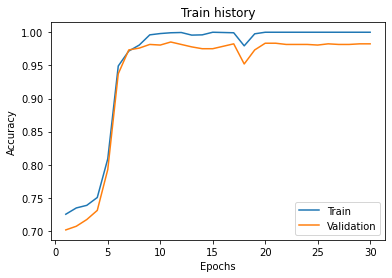

In [10]:
from matplotlib import pyplot as plt
epochs = list(range(1, 31))

plt.plot(epochs, best_model_history[0])
plt.plot(epochs, best_model_history[1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train history")
plt.legend(["Train", "Validation"])
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

def print_performance(y, y_predict):
    ConfusionMatrixDisplay.from_predictions(y, y_predict)
    plt.show()

    print("accuracy: ", accuracy_score(y, y_predict))
    print("precision: ", precision_score(y, y_predict))
    print("recall: ", recall_score(y, y_predict))
    print("f1: ", f1_score(y, y_predict))

### Performance of GRU model on train set

C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


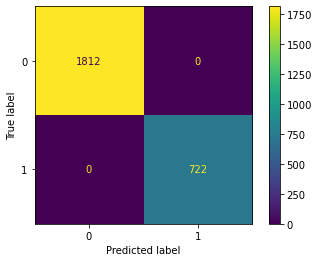

accuracy:  1.0
precision:  1.0
recall:  1.0
f1:  1.0


In [12]:
y_train = torch.LongTensor([])
gru_train_result = torch.LongTensor([])

for batch in train_loader:
    x = batch.mail
    y = batch.label.cpu()

    logit = best_model(x)
    gru_result = ((logit >= 0) * 1).cpu()

    y_train = torch.concat([y_train, y])
    gru_train_result = torch.concat([gru_train_result, y])

print_performance(y_train, gru_train_result)

### Performance of GRU model on validation set

C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


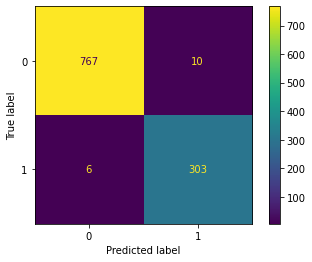

accuracy:  0.9852670349907919
precision:  0.9680511182108626
recall:  0.9805825242718447
f1:  0.9742765273311897


In [13]:
for batch in val_loader:
    x = batch.mail
    y = batch.label.cpu()

    logit = best_model(x)
    gru_val_result = ((logit >= 0) * 1).cpu().numpy()

print_performance(y, gru_val_result)

### Prepare datas for naive bayse

In [14]:
import numpy as np

X_train = []
y_train = []
X_val = []
y_val = []

for i in train_data:
    X_train.append(" ".join(i.mail))
    y_train.append(i.label)

for i in val_data:
    X_val.append(" ".join(i.mail))
    y_val.append(i.label)

X_train = np.array(X_train)
y_train = np.array(y_train).astype(int)
X_val = np.array(X_val)
y_val = np.array(y_val).astype(int)

print(vars(train_data[0]))
print("label: ", y_train[0], ", mail: ", X_train[0])

print(vars(val_data[0]))
print("label: ", y_val[0], ", mail: ", X_val[0])

{'id': '1163', 'label': '1', 'mail': ['subject:', 'copy', 'from', 'cassette', 'tape', 'to', 'mp', '3', 'and', 'vice', 'versa', '@', '$', '137', '.', '00', 'plusdeck', '2', 'tape', '-', 'rw', 'pc', 'cassette', 'deck', '-', 'tape', 'to', 'mp', '3', '$', '137', '.', '00', 'old', 'school', 'to', 'new', 'school', '!', 'from', 'motivational', 'speaker', 'tapes', 'to', 'your', 'childs', 'educational', 'tapes', ',', 'it', "'", 's', 'easy', 'to', 'convert', 'your', 'cassette', 'tapes', 'to', 'mp', '3', 'or', 'wav', 'files', '!', 'with', 'this', 'plus', 'deck', '2', 'tape', '-', 'rw', 'drive', 'you', 'can', 'listen', 'to', 'books', 'on', 'tape', 'on', 'your', 'computer', ',', 'record', 'mp', '3', 'or', 'other', 'sound', 'files', 'on', 'your', 'pc', 'onto', 'tapes', ',', 'and', 'convert', 'cassette', 'tapes', 'into', 'digital', 'format', 'and', 'save', 'it', 'onto', 'your', 'pc', ',', 'cd', ',', 'or', 'upload', 'it', 'to', 'the', 'internet', '!', 'save', 'up', 'to', '25', 'cassette', 'tapes', 'on

### Make word of bag and transform to feature vector

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=str.split, min_df=1)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

print("subject dtm shape: " + str(X_train_vectorized.shape))

subject dtm shape: (2534, 32689)


### Train Naive Bayse

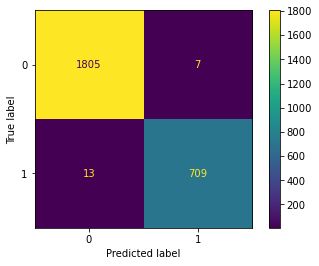

accuracy:  0.9921073401736386
precision:  0.9902234636871509
recall:  0.981994459833795
f1:  0.9860917941585535


In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

NB_model = MultinomialNB(alpha=0.00005)
NB_model.fit(X_train_vectorized, y_train)

nb_train_result = NB_model.predict(X_train_vectorized)
print_performance(y_train, nb_train_result)

### Test validation set on Naive Bayse

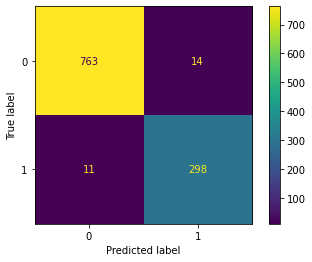

accuracy:  0.9769797421731123
precision:  0.9551282051282052
recall:  0.9644012944983819
f1:  0.9597423510466989


In [26]:
nb_val_result = NB_model.predict(X_val_vectorized)

print_performance(y_val, nb_val_result)

### Train SVM

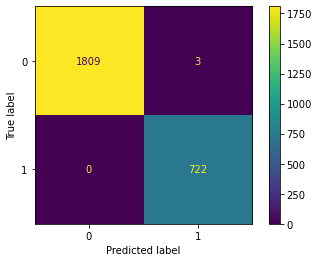

accuracy:  0.9988161010260458
precision:  0.9958620689655172
recall:  1.0
f1:  0.9979267449896337


In [25]:
from sklearn.svm import SVC

SVM_model = SVC(kernel="linear", C=0.1, probability=True)
SVM_model.fit(X_train_vectorized, y_train)

svm_train_result = SVM_model.predict(X_train_vectorized)
print_performance(y_train, svm_train_result)

### Test validation set on SVM

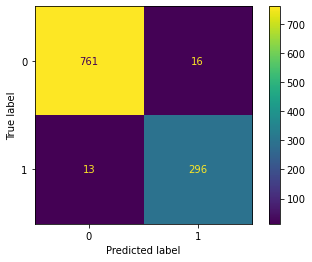

accuracy:  0.9732965009208103
precision:  0.9487179487179487
recall:  0.9579288025889967
f1:  0.9533011272141707


In [27]:
svm_val_result = SVM_model.predict(X_val_vectorized)

print_performance(y_val, svm_val_result)

### Performance of ensemble model on train data

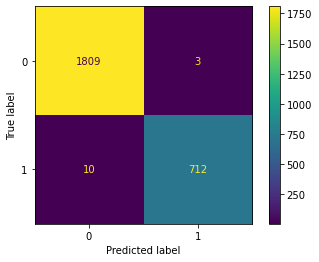

accuracy:  0.994869771112865
precision:  0.9958041958041958
recall:  0.9861495844875346
f1:  0.9909533750869868


In [28]:
ensembled_train_result = ((gru_train_result + nb_train_result + svm_train_result) >= 2) * 1
print_performance(y_train, ensembled_train_result)

### Performance of ensemble model on validation data

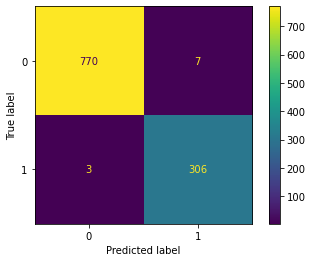

accuracy:  0.990791896869245
precision:  0.9776357827476039
recall:  0.9902912621359223
f1:  0.9839228295819936


In [29]:
ensembled_val_result = ((gru_val_result + nb_val_result + svm_val_result) >= 2) * 1
print_performance(y_val, ensembled_val_result)

### Predict on test data

In [30]:
test_data = TabularDataset(path="./data/test.csv",
                                 format="csv",
                                 fields=[("id" , id_field), ("mail", mail_field)],
                                 skip_header=True)

test_loader = Iterator(dataset=test_data, batch_size=len(test_data), device="cuda", shuffle=False)

best_model.eval()

for batch in test_loader:
    x = batch.mail
    id = batch.id

    print(id)

    logit = best_model(x)
    gru_test_result = ((logit >= 0) * 1).cpu().numpy()

X_test = []

for i in test_data:
    X_test.append(" ".join(i.mail))

X_test_vectorized = vectorizer.transform(X_test)
nb_test_result = NB_model.predict(X_test_vectorized)
svm_test_result = SVM_model.predict(X_test_vectorized)

ensembled_predicted = ((gru_test_result + nb_test_result + svm_test_result) >= 2) * 1

print(ensembled_predicted)

tensor([   0,    1,    2,  ..., 1548, 1549, 1550], device='cuda:0')


C:\Users\hanchaa\anaconda3\envs\COSE362\lib\site-packages\torch\nn\modules\rnn.py:849: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


[0 0 0 ... 1 0 0]


In [31]:
import csv

f = open("result.csv", "w", newline="")
wr = csv.writer(f)
wr.writerow(["id", "label"])

id = 0
for i in ensembled_predicted:
    wr.writerow([id, i])
    id += 1

f.close()